In [42]:
import os
import pandas as pd
from IPython.display import display

# Liste til at samle dataframes
sampled_dfs = []

# Find nuværende mappe
base_dir = os.getcwd()

# Gennemgå ALLE filer i undermapper (rekursivt)
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "T_ONTIME_REPORTING.csv":  # Matcher filnavne præcist
            csv_path = os.path.join(root, file)
            try:
                # Robust indlæsning (sniffer separator, skipper dårlige linjer)
                try:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="utf-8", on_bad_lines="skip")
                except Exception:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="latin1", on_bad_lines="skip")

                print(f"📂 Indlæst: {csv_path}")

                # Tag en stikprøve på maks 300 rækker pr. fil
                sample_size = min(300, len(df))
                sample = df.sample(sample_size, random_state=42)
                sampled_dfs.append(sample)

                print(f"✅ Tilføjet: {csv_path} ({sample_size} rækker)")

            except Exception as e:
                print(f"⚠️ Fejl ved indlæsning af {csv_path}: {e}")

# Kombinér alle filer til ét samlet dataframe
if sampled_dfs:
    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"\n📊 Samlet dataframe med {len(df):,} rækker fra {len(sampled_dfs)} filer.")
    display(df.head())
else:
    print("❌ Ingen data fundet – tjek filnavne eller placering.")

📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/April/T_ONTIME_REPORTING.csv
✅ Tilføjet: /Users/robinribelrifai/Desktop/Data months/April/T_ONTIME_REPORTING.csv (300 rækker)
📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/december/T_ONTIME_REPORTING.csv
✅ Tilføjet: /Users/robinribelrifai/Desktop/Data months/december/T_ONTIME_REPORTING.csv (300 rækker)
📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/february/T_ONTIME_REPORTING.csv
✅ Tilføjet: /Users/robinribelrifai/Desktop/Data months/february/T_ONTIME_REPORTING.csv (300 rækker)
📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/June/T_ONTIME_REPORTING.csv
✅ Tilføjet: /Users/robinribelrifai/Desktop/Data months/June/T_ONTIME_REPORTING.csv (300 rækker)
📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/July/T_ONTIME_REPORTING.csv
✅ Tilføjet: /Users/robinribelrifai/Desktop/Data months/July/T_ONTIME_REPORTING.csv (300 rækker)
📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/August/T_ONTIME_REPORTING.csv
✅ Tilføj

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,...,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,FLIGHTS,DISTANCE
0,2024,4,12,18,3,12/18/2024 12:00:00 AM,1293.0,12892,LAX,California,...,"Seattle, WA",Washington,600,553.0,858.0,846.0,0.0,0800-0859,1.0,954.0
1,2024,4,12,13,5,12/13/2024 12:00:00 AM,3764.0,13930,ORD,Illinois,...,"Indianapolis, IN",Indiana,1338,1336.0,1537.0,1531.0,0.0,1500-1559,1.0,177.0
2,2024,4,12,31,2,12/31/2024 12:00:00 AM,1788.0,14747,SEA,Washington,...,"Houston, TX",Texas,704,701.0,1327.0,1315.0,0.0,1300-1359,1.0,1874.0
3,2024,4,12,22,7,12/22/2024 12:00:00 AM,5487.0,11057,CLT,North Carolina,...,"Jacksonville/Camp Lejeune, NC",North Carolina,2047,2139.0,2156.0,2230.0,1.0,2100-2159,1.0,191.0
4,2024,4,12,13,5,12/13/2024 12:00:00 AM,5374.0,11150,CSG,Georgia,...,"Atlanta, GA",Georgia,1742,1734.0,1845.0,1814.0,0.0,1800-1859,1.0,83.0


In [54]:
# --- Prepare data for Logistic Classification Model (Leakage-Free Version) ---
# This cell creates the delay target variable and time-based predictors that can be known before departure.

import numpy as np
import pandas as pd

# --- Convert HHMM → minutes since midnight ---
# This function transforms scheduled or actual departure times into total minutes since midnight.
def hhmm_to_minutes(x):
    try:
        x = int(float(str(x).strip()))
        h, m = x // 100, x % 100
        return min(h * 60 + m, 1439)  # cap at 23:59
    except:
        return np.nan

# --- Create minute-based columns for actual and scheduled departure times ---
if "DEP_TIME" in df.columns:
    df["DEP_TIME_MIN"] = df["DEP_TIME"].apply(hhmm_to_minutes)

if "CRS_DEP_TIME" in df.columns:
    df["CRS_DEP_TIME_MIN"] = df["CRS_DEP_TIME"].apply(hhmm_to_minutes)

# --- Calculate delay in minutes (only for creating the target variable) ---
# Note: This column will NOT be used as an input feature to prevent data leakage.
if {"DEP_TIME_MIN", "CRS_DEP_TIME_MIN"}.issubset(df.columns):
    df["DEP_DELAY_MIN"] = df["DEP_TIME_MIN"] - df["CRS_DEP_TIME_MIN"]

print("\n'DEP_DELAY_MIN' successfully calculated.")
display(df[["DEP_TIME_MIN", "CRS_DEP_TIME_MIN", "DEP_DELAY_MIN"]].head())

# --- Create the binary target variable for logistic classification ---
# 1 = delayed more than 15 minutes, 0 = on time
df["DELAYED"] = (df["DEP_DELAY_MIN"] > 15).astype(int)

print("\nTarget variable 'DELAYED' created (1 = delayed, 0 = on time).")
display(df[["DEP_DELAY_MIN", "DELAYED"]].head())

# --- Create cyclic time features for departure time ---
# These encode the time of day in a circular format to capture daily patterns
# (e.g., 23:59 and 00:01 are close in time, not far apart).
if "CRS_DEP_TIME_MIN" in df.columns:
    df["DEP_TIME_sin"] = np.sin(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
    df["DEP_TIME_cos"] = np.cos(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
    print("\nCyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.")
    display(df[["CRS_DEP_TIME_MIN", "DEP_TIME_sin", "DEP_TIME_cos"]].head())




'DEP_DELAY_MIN' successfully calculated.


,DEP_TIME_MIN,CRS_DEP_TIME_MIN,DEP_DELAY_MIN
2,421,424,-3
3,1299,1247,52
5,576,585,-9
6,1182,1130,52
10,518,520,-2



Target variable 'DELAYED' created (1 = delayed, 0 = on time).


,DEP_DELAY_MIN,DELAYED
2,-3,0
3,52,1
5,-9,0
6,52,1
10,-2,0



Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.


,CRS_DEP_TIME_MIN,DEP_TIME_sin,DEP_TIME_cos
2,424,0.961262,-0.275637
3,1247,-0.746057,0.665882
5,585,0.555570,-0.831470
6,1130,-0.976296,0.216440
10,520,0.766044,-0.642788


In [55]:
# --- Convert DEP_TIME_MIN into 15-minute bins (categorical) ---
df["DEP_TIME_BIN"] = pd.cut(
    df["DEP_TIME_MIN"],
    bins=range(0, 1441, 15),
    labels=[f"{h:02d}:{m:02d}" for h in range(24) for m in range(0, 60, 15)]
)

print("\n🕒 Sample of 15-minute bins:")
display(df[["DEP_TIME_MIN", "DEP_TIME_BIN"]].head())

# --- Select model features ---
selected_features = ["DEP_TIME_BIN", "DAY_OF_WEEK", "ORIGIN_AIRPORT_ID", "ORIGIN", "DEST"]

# --- Keep only relevant rows (drop NaN) ---
df_model = df[selected_features + ["DELAYED"]].dropna()

X = df_model[selected_features]
y = df_model["DELAYED"]

print(f"\n📊 Final dataset ready for modeling: {len(X)} rows, {len(selected_features)} features.")
display(X.head())



🕒 Sample of 15-minute bins:


,DEP_TIME_MIN,DEP_TIME_BIN
2,421,07:00
3,1299,21:30
5,576,09:30
6,1182,19:30
10,518,08:30



📊 Final dataset ready for modeling: 458 rows, 5 features.


,DEP_TIME_BIN,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,ORIGIN,DEST
2,07:00,2,14747,SEA,IAH
3,21:30,7,11057,CLT,OAJ
5,09:30,3,11298,DFW,DTW
6,19:30,6,10423,AUS,DAL
10,08:30,3,14908,SNA,CLT


✅ Numeric features found: ['MONTH', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'DISTANCE', 'DEP_TIME_sin', 'DEP_TIME_cos']
✅ Categorical features found: ['ORIGIN', 'DEST']

📊 Dataset prepared for training:


,MONTH,DAY_OF_WEEK,DAY_OF_MONTH,DISTANCE,DEP_TIME_sin,DEP_TIME_cos,ORIGIN,DEST
2,12,2,31,1874.0,0.964787,-0.263031,SEA,IAH
3,12,7,22,191.0,-0.577145,0.816642,CLT,OAJ
5,12,3,25,986.0,0.587785,-0.809017,DFW,DTW
6,12,6,28,189.0,-0.902585,0.430511,AUS,DAL
10,12,3,25,2099.0,0.771625,-0.636078,SNA,CLT



Training set: 366 rows | Test set: 92 rows

 Logistic Regression model trained successfully with OneHotEncoding applied!

 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        70
           1       0.67      0.36      0.47        22

    accuracy                           0.80        92
   macro avg       0.75      0.65      0.68        92
weighted avg       0.79      0.80      0.78        92

ROC-AUC Score: 0.788


<Figure size 500x400 with 0 Axes>

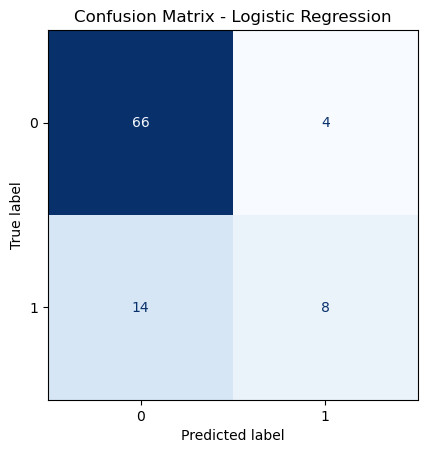

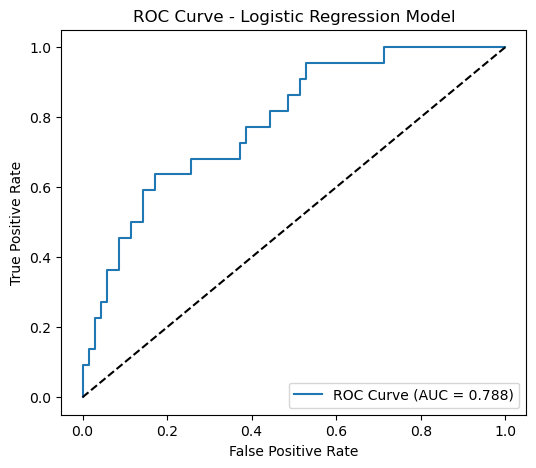

In [60]:
# --- ✅ Feature preparation and cleaning before model training ---

# Define which columns to include as features
feature_cols_numeric = [
    "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH",
    "DISTANCE", "DEP_TIME_sin", "DEP_TIME_cos"
]


feature_cols_categorical = ["ORIGIN", "DEST", "ROUTE"]

# Make sure only columns that actually exist in the dataframe are used
feature_cols_numeric = [col for col in feature_cols_numeric if col in df.columns]
feature_cols_categorical = [col for col in feature_cols_categorical if col in df.columns]

print("✅ Numeric features found:", feature_cols_numeric)
print("✅ Categorical features found:", feature_cols_categorical)

# Drop any rows with missing values in the selected columns (this keeps the data clean)
df = df.dropna(subset=feature_cols_numeric + feature_cols_categorical + ["DELAYED"])

# Define X (input features) and y (target variable)
X = df[feature_cols_numeric + feature_cols_categorical]
y = df["DELAYED"]

print("\n📊 Dataset prepared for training:")
display(X.head())

# -------------------------------------------------------------------

# --- ✂️ Split the dataset into training and testing sets ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train)} rows | Test set: {len(X_test)} rows")

# -------------------------------------------------------------------

# --- ⚙️ Build preprocessing and logistic regression pipeline ---
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Combine numeric and categorical transformations:
# - Numeric features are scaled using StandardScaler
# - Categorical features are encoded using OneHotEncoder
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), feature_cols_numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_categorical)
])

# Define the logistic regression model
log_reg = LogisticRegression(max_iter=2000, solver="lbfgs")

# Build the pipeline (this ensures all preprocessing happens inside the model)
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", log_reg)
])

# -------------------------------------------------------------------

# --- 🚀 Train the logistic regression model ---
pipeline.fit(X_train, y_train)
print("\n Logistic Regression model trained successfully with OneHotEncoding applied!")

# -------------------------------------------------------------------

# --- 📈 Evaluate model performance ---
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Print classification metrics
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Compute and display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.3f}")

# Plot confusion matrix
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues", colorbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression Model")
plt.legend(loc="lower right")
plt.show()


In [57]:
# Add holiday attribute
df['Holiday?'] = (
    ((df['MONTH'] == 12) & (df['DAY_OF_MONTH'] >= 20)) |  # Dec 20–31
    ((df['MONTH'] == 1) & (df['DAY_OF_MONTH'] <= 5))   |  # Jan 1–5
    (df['MONTH'].isin([7, 8]))                           # July & August
)
# Filtrér så vi kun viser data fra holiday-perioden
df = df[df["Holiday?"] == True]
df

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,...,FLIGHTS,DISTANCE,DEP_TIME_MIN,CRS_DEP_TIME_MIN,DEP_DELAY_MIN,DELAYED,DEP_TIME_BIN,Holiday?,DEP_TIME_sin,DEP_TIME_cos
2,2024,4,12,31,2,12/31/2024 12:00:00 AM,1788.0,14747,SEA,Washington,...,1.0,1874.0,421,424,-3,0,07:00,True,0.961262,-0.275637
3,2024,4,12,22,7,12/22/2024 12:00:00 AM,5487.0,11057,CLT,North Carolina,...,1.0,191.0,1299,1247,52,1,21:30,True,-0.746057,0.665882
5,2024,4,12,25,3,12/25/2024 12:00:00 AM,3176.0,11298,DFW,Texas,...,1.0,986.0,576,585,-9,0,09:30,True,0.555570,-0.831470
6,2024,4,12,28,6,12/28/2024 12:00:00 AM,4284.0,10423,AUS,Texas,...,1.0,189.0,1182,1130,52,1,19:30,True,-0.976296,0.216440
10,2024,4,12,25,3,12/25/2024 12:00:00 AM,1539.0,14908,SNA,California,...,1.0,2099.0,518,520,-2,0,08:30,True,0.766044,-0.642788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,2024,3,8,15,4,8/15/2024 12:00:00 AM,714.0,14747,SEA,Washington,...,1.0,1050.0,756,764,-8,0,12:30,True,-0.190809,-0.981627
3296,2024,3,8,14,3,8/14/2024 12:00:00 AM,6208.0,10372,ASE,Colorado,...,1.0,701.0,856,868,-12,0,14:15,True,-0.601815,-0.798636
3297,2024,3,8,21,3,8/21/2024 12:00:00 AM,5458.0,10980,CHA,Tennessee,...,1.0,241.0,646,658,-12,0,10:45,True,0.267238,-0.963630
3298,2024,3,8,29,4,8/29/2024 12:00:00 AM,2337.0,14100,PHL,Pennsylvania,...,1.0,453.0,561,574,-13,0,09:15,True,0.594823,-0.803857


In [58]:
# --- Create sine and cosine features for departure time ---
# Converts the time of day (in minutes) into circular values between -1 and 1
# This allows the model to understand the cyclical nature of time (e.g. 23:59 and 00:01 are close).

import numpy as np

if "DEP_TIME_MIN" in df.columns:
    df["DEP_TIME_sin"] = np.sin(2 * np.pi * df["DEP_TIME_MIN"].fillna(0) / 1440)
    df["DEP_TIME_cos"] = np.cos(2 * np.pi * df["DEP_TIME_MIN"].fillna(0) / 1440)
    print("Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.")
else:
    print("Error: Column 'DEP_TIME_MIN' not found. Make sure it is created before running this cell.")

display(df[["DEP_TIME_MIN", "DEP_TIME_sin", "DEP_TIME_cos"]].head())


Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.


,DEP_TIME_MIN,DEP_TIME_sin,DEP_TIME_cos
2,421,0.964787,-0.263031
3,1299,-0.577145,0.816642
5,576,0.587785,-0.809017
6,1182,-0.902585,0.430511
10,518,0.771625,-0.636078


Holiday dataset created with 458 rows out of 458 total flights.
Logistic Regression model for holiday flights trained successfully.

Classification Report (Holiday flights):
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        70
           1       0.45      0.64      0.53        22

    accuracy                           0.73        92
   macro avg       0.66      0.70      0.67        92
weighted avg       0.77      0.73      0.74        92

ROC-AUC Score (Holiday flights): 0.790


<Figure size 500x400 with 0 Axes>

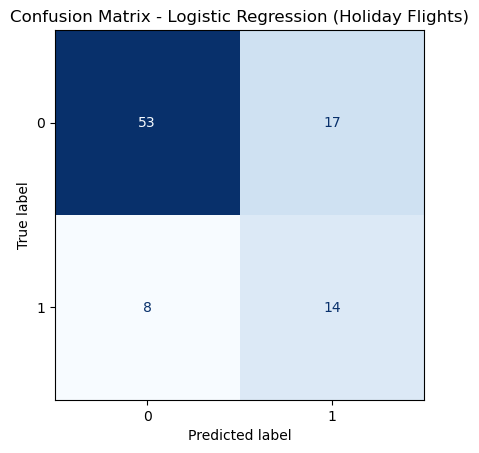

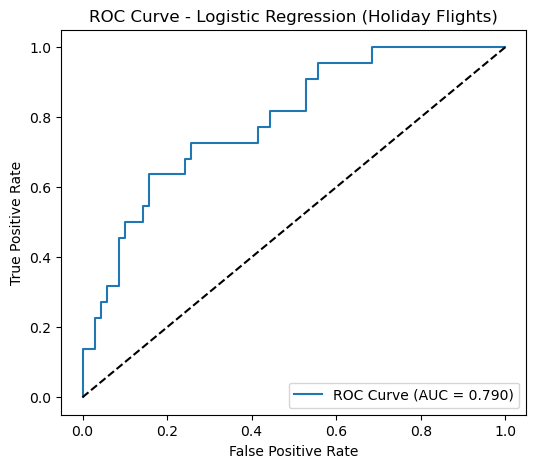

In [59]:
# --- Logistic Regression Model Focused on Holiday Flights ---
# This model isolates data from specific holiday periods (e.g., Christmas, New Year, July, and August)
# to examine whether flight delays occur more frequently during these high-traffic times.

# Step 1: Define holiday periods
df["Holiday?"] = (
    ((df["MONTH"] == 12) & (df["DAY_OF_MONTH"] >= 20)) |  # December 20–31
    ((df["MONTH"] == 1) & (df["DAY_OF_MONTH"] <= 5))   |  # January 1–5
    (df["MONTH"].isin([7, 8]))                            # July and August
)

# Step 2: Keep only flights that took place during holiday periods
df_holiday = df[df["Holiday?"] == True].copy()
print(f"Holiday dataset created with {len(df_holiday)} rows out of {len(df)} total flights.")

# Step 3: Select the features and target variable for modeling
# We include time, distance, and location-related variables that are available before the flight departs.
feature_cols_numeric = [
    "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH",
    "DISTANCE", "DEP_TIME_sin", "DEP_TIME_cos"
]
feature_cols_categorical = ["ORIGIN", "DEST"]
target_col = "DELAYED"

# Step 4: Remove rows with missing values to ensure the model trains correctly
df_holiday = df_holiday.dropna(subset=feature_cols_numeric + feature_cols_categorical + [target_col])

# Step 5: Define X (independent variables) and y (dependent variable)
X_holiday = df_holiday[feature_cols_numeric + feature_cols_categorical]
y_holiday = df_holiday[target_col]

# Step 6: Split the data into training and test sets
# The training set is used to train the model, while the test set evaluates its performance.
from sklearn.model_selection import train_test_split
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_holiday, y_holiday, test_size=0.2, random_state=42, stratify=y_holiday
)

# Step 7: Preprocessing and model setup
# - Numeric variables are standardized (scaled) using StandardScaler.
# - Categorical variables are one-hot encoded so the model can interpret text labels.
# - The model uses class_weight="balanced" to compensate for class imbalance.
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocessor_h = ColumnTransformer(transformers=[
    ("num", StandardScaler(), feature_cols_numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_categorical)
])

log_reg_h = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced")

pipeline_h = Pipeline(steps=[
    ("preprocessor", preprocessor_h),
    ("classifier", log_reg_h)
])

# Step 8: Train the model on holiday data
pipeline_h.fit(X_train_h, y_train_h)
print("Logistic Regression model for holiday flights trained successfully.")

# Step 9: Evaluate model performance
# We evaluate the model using metrics such as accuracy, recall, precision, and ROC-AUC.
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Generate predictions for the test set
y_pred_h = pipeline_h.predict(X_test_h)
y_prob_h = pipeline_h.predict_proba(X_test_h)[:, 1]

# Step 10: Display classification metrics
print("\nClassification Report (Holiday flights):")
print(classification_report(y_test_h, y_pred_h))

# Compute and print the ROC-AUC score
roc_auc_h = roc_auc_score(y_test_h, y_prob_h)
print(f"ROC-AUC Score (Holiday flights): {roc_auc_h:.3f}")

# Step 11: Plot the confusion matrix
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix(y_test_h, y_pred_h)).plot(cmap="Blues", colorbar=False)
plt.title("Confusion Matrix - Logistic Regression (Holiday Flights)")
plt.show()

# Step 12: Plot the ROC curve
fpr_h, tpr_h, _ = roc_curve(y_test_h, y_prob_h)
plt.figure(figsize=(6,5))
plt.plot(fpr_h, tpr_h, label=f"ROC Curve (AUC = {roc_auc_h:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Holiday Flights)")
plt.legend(loc="lower right")
plt.show()
